# **Encoder** **CNN**

In [ ]:
import math
from pycocotools.coco import COCO
import torch.nn as nn
import torch
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import json
import os
import numpy as np
import sys


# Define the EncoderCNN class
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        # Disable Learning for parameters
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features

In [ ]:
# Load the image
image_path = "/content/drive/MyDrive/cocoapi/3.jpeg"  # Change this to the path of your image
image = Image.open(image_path).convert('RGB')

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_tensor = preprocess(image).unsqueeze(0)

In [ ]:
import torch
#initialize the encoder
embed_size =256
encoder = EncoderCNN(embed_size)

# Move encoder to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)

# Set encoder to evaluation mode
encoder.eval()

# Move image tensor to device
image_tensor = image_tensor.to(device)

# Forward pass the image through the encoder
output = image_tensor
for name, module in encoder.resnet.named_children():
    output = module(output)
    print(f"Output after {name}: {output.shape}")

# Get the final feature vector
output = output.view(output.size(0), -1) # Corrected size to view
output = encoder.embed(output)
print(f"Final feature vector shape: {output.shape}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s]


Output after 0: torch.Size([1, 64, 112, 112])
Output after 1: torch.Size([1, 64, 112, 112])
Output after 2: torch.Size([1, 64, 112, 112])
Output after 3: torch.Size([1, 64, 56, 56])
Output after 4: torch.Size([1, 256, 56, 56])
Output after 5: torch.Size([1, 512, 28, 28])
Output after 6: torch.Size([1, 1024, 14, 14])
Output after 7: torch.Size([1, 2048, 7, 7])
Output after 8: torch.Size([1, 2048, 1, 1])
Final feature vector shape: torch.Size([1, 256])


In [ ]:
print("embedding vector: ",output)

embedding vector:  tensor([[ 5.9401e-01, -8.5509e-02, -3.6958e-01,  2.9979e-01,  2.9809e-01,
          2.2242e-02, -4.5696e-01,  7.4129e-01,  5.8621e-02, -2.7966e-02,
         -1.8417e-01,  1.4704e-01,  1.0603e-01,  3.8418e-01, -2.2761e-01,
         -3.6902e-01, -6.9961e-02,  1.1408e-01,  1.0582e-01,  4.2821e-01,
          2.5784e-01, -4.4245e-03, -7.3713e-01,  9.8027e-01,  5.2049e-01,
          1.6415e-01,  2.0546e-01,  1.6749e-01, -7.9272e-01,  2.6401e-02,
         -4.8032e-01,  5.9852e-01,  8.6376e-02,  6.2097e-01,  4.9006e-01,
         -1.1845e-01, -1.8862e-02,  2.2701e-01,  9.0045e-02, -6.4689e-01,
          5.8335e-01, -1.5354e-01, -2.6145e-01,  3.9683e-01,  4.5978e-01,
         -2.6018e-01, -9.0617e-02,  6.9170e-01,  1.5423e-01,  4.0942e-01,
         -4.3529e-02,  3.2675e-01,  8.3529e-02,  1.0041e+00,  8.5200e-04,
         -1.0095e-01,  2.5820e-01,  2.4713e-01,  1.9044e-01,  7.8517e-02,
          6.4169e-02,  2.1261e-01,  3.1967e-01,  5.2695e-01, -9.3407e-02,
         -1.3161e-0

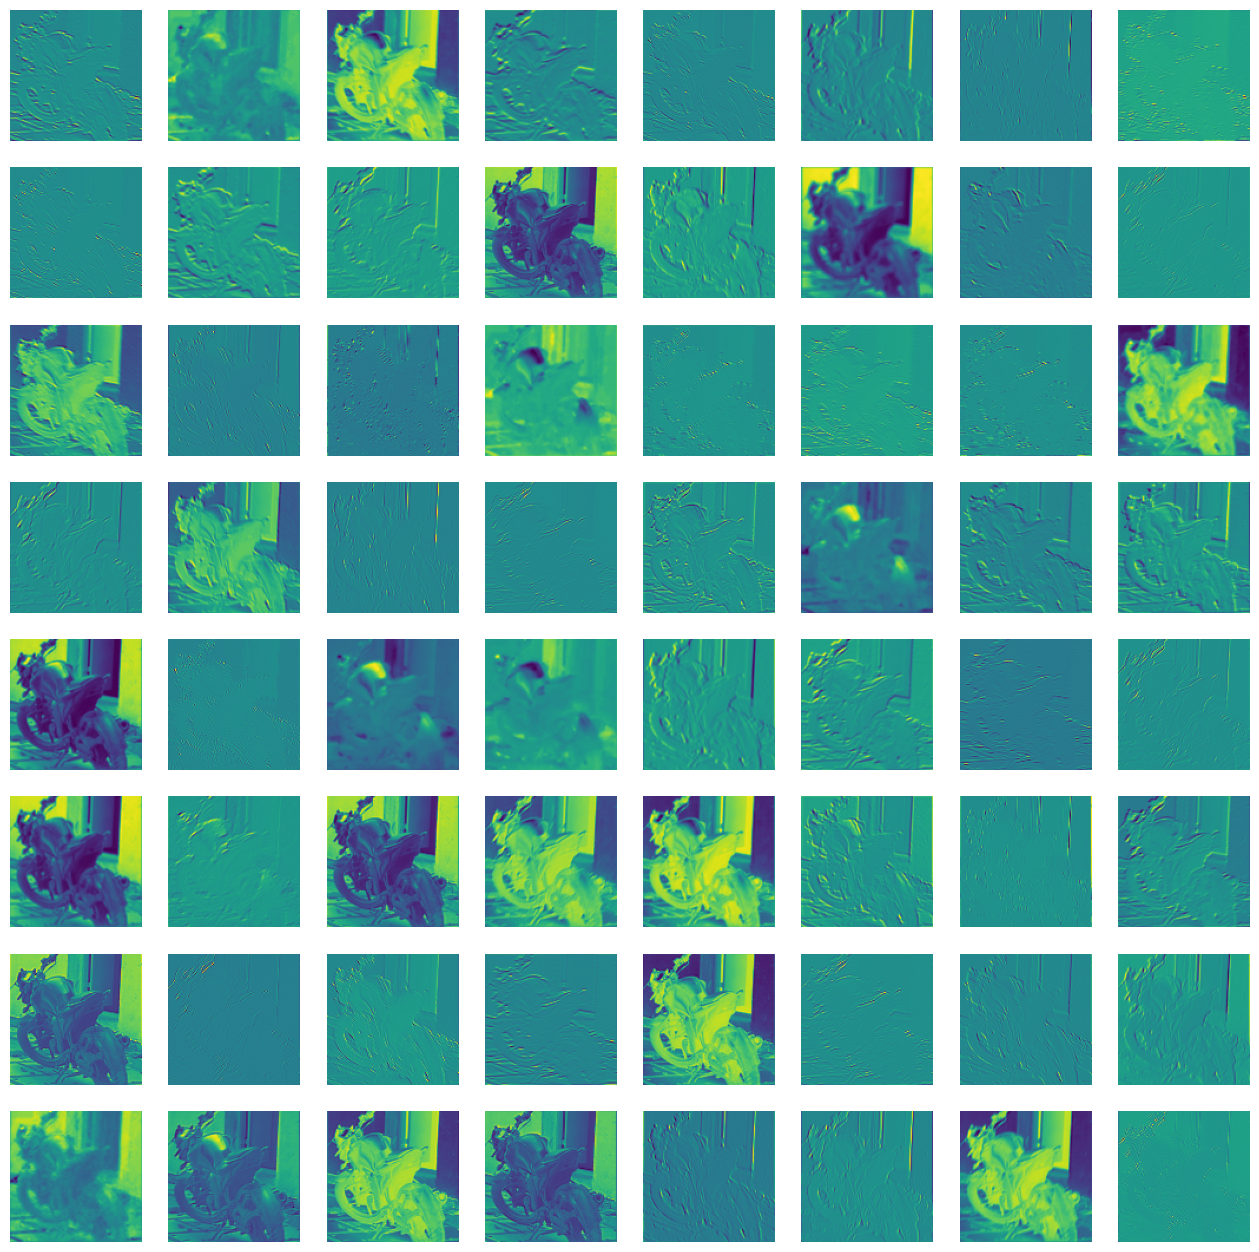

In [ ]:
import matplotlib.pyplot as plt
# Move image tensor to device
image_tensor = image_tensor.to(device)

#forward pass the image through the encoder
output = image_tensor
feature_maps = []
for name, module in encoder.resnet.named_children():
    output = module(output)
    if isinstance(output, torch.Tensor):
        feature_maps.append(output.clone().detach())

# Plot all feature maps from the first layer
num_features = feature_maps[0].shape[1]
fig, axs = plt.subplots(8, 8, figsize=(16, 16))

for i in range(8):
  for j in range(8):
    feature_map = feature_maps[0][0, i * 8 + j].cpu().numpy()
    axs[i, j].imshow(feature_map, cmap='viridis')
    axs[i, j].axis('off')

plt.show()


In [ ]:
import os
os.environ['PYTHONPATH'] = "/content/data_loader.py"

In [ ]:
import sys
sys.path.append("/content/data_loader.py")

In [ ]:
from torch.utils.data import DataLoader as get_loader

In [ ]:
from pycocotools.coco import COCO
import nltk
import torch
import numpy as np
import torch.utils.data as data
from torchvision import transforms

nltk.download("punkt")

%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

cocoapi_dir = "/content/drive/My Drive/cocoapi"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install nltk
import nltk
from google.colab import drive
import sys
import os
import torch
import pickle
import numpy as np
import torch.utils.data as data
from torchvision import transforms
from torch.utils.data import DataLoader
from pycocotools.coco import COCO
from PIL import Image
from collections import Counter

nltk.download("punkt")
nltk.download("punkt_tab")

drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/cocoapi/annotations')

from vocabulary import Vocabulary

transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

cocoapi_dir = "/content/drive/MyDrive/cocoapi/annotations"
vocab_file = "/content/drive/MyDrive/cocoapi/vocab.pkl"
vocab_threshold = 5
batch_size = 10
image_dir = '/content/drive/MyDrive/cocoapi/train2017' # Added image directory path

def load_vocab(vocab_file):
    if not os.path.exists(vocab_file):
        print(f"⚠️ Vocabulary file not found: {vocab_file}")
        return None

    try:
        with open(vocab_file, "rb") as f:
            vocab_data = pickle.load(f, encoding="latin1")

        if isinstance(vocab_data, dict) and 'word2idx' in vocab_data and 'idx2word' in vocab_data:
            vocab = Vocabulary()
            vocab.word2idx = vocab_data['word2idx']
            vocab.idx2word = vocab_data['idx2word']
            vocab.idx = len(vocab.word2idx)
            return vocab
        elif isinstance(vocab_data, Vocabulary):
            return vocab_data
        else:
            print("⚠️ Error: Invalid vocab format.")
            return None

    except Exception as e:
        print(f"⚠️ Failed to load vocabulary: {e}")
        return None

def save_vocab(vocab, vocab_file):
    with open(vocab_file, 'wb') as f:
        pickle.dump(vocab, f)
    print(f"✅ Vocabulary saved successfully at {vocab_file}")

class CocoDataset(data.Dataset):
    def __init__(self, cocoapi_path, transform=None, mode='train', vocab_threshold=5, vocab_file=None, image_dir=None): # Added image_dir
        self.transform = transform
        self.coco = COCO(os.path.join(cocoapi_path, f'captions_{mode}2017.json'))
        self.ids = list(self.coco.anns.keys())
        self.vocab = load_vocab(vocab_file) if vocab_file else self.build_vocab(vocab_threshold)
        if self.vocab is None:
            raise ValueError("❌ Failed to load or build vocabulary!")
        self.image_dir = image_dir # Added image_dir to class

    def __getitem__(self, index):
        image_id = self.ids[index]
        caption = self.coco.anns[image_id]['caption']
        image_info = self.coco.loadImgs(self.coco.anns[image_id]['image_id'])[0]
        image_path = os.path.join(self.image_dir, image_info['file_name']) # Use image_dir

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, caption

    def __len__(self):
        return len(self.ids)

    def build_vocab(self, threshold):
        counter = Counter()
        for id in self.ids:
            caption = str(self.coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

        words = [word for word, cnt in counter.items() if cnt >= threshold]

        vocab = Vocabulary(threshold)
        vocab.add_word("<pad>")
        vocab.add_word("<start>")
        vocab.add_word("<end>")
        vocab.add_word("<unk>")

        for word in words:
            vocab.add_word(word)

        save_vocab(vocab, vocab_file)

        return vocab

vocab = load_vocab(vocab_file)
if vocab is None:
    print("⚠️ Vocabulary is missing or invalid. Rebuilding vocabulary...")
    dataset_for_vocab = CocoDataset(
        cocoapi_dir,
        transform=transform_train,
        mode='train',
        vocab_threshold=vocab_threshold,
        vocab_file=None,
        image_dir=image_dir # Added image_dir
    )
    save_vocab(dataset_for_vocab.vocab, vocab_file)
    vocab = dataset_for_vocab.vocab

coco_dataset = CocoDataset(
    cocoapi_dir,
    transform=transform_train,
    mode='train',
    vocab_threshold=vocab_threshold,
    vocab_file=vocab_file,
    image_dir=image_dir # Added image_dir
)

data_loader = DataLoader(
    dataset=coco_dataset,
    batch_size=batch_size,
    shuffle=True
)

if coco_dataset.vocab:
    print("✅ Vocabulary loaded successfully!")
    print("✅ Vocabulary size:", len(coco_dataset.vocab.word2idx))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
loading annotations into memory...
Done (t=4.01s)
creating index...
index created!
✅ Vocabulary loaded successfully!
✅ Vocabulary size: 10322


In [ ]:
import os
print(os.listdir('/content/drive/MyDrive/cocoapi/annotations/'))  # Check if vocabulary.py and annotation files exist
print(os.listdir('/content/drive/MyDrive/cocoapi/train2017/'))  # Ensure images exist


['instances_val2017.json', 'captions_train2017.json', 'captions_val2017.json', 'person_keypoints_train2017.json', 'person_keypoints_val2017.json', '__pycache__', '.ipynb_checkpoints', 'data_loader.py', 'coco_dataset.py', 'vocab.pkl', 'vocabulary.py', 'data_loader_val.py', 'model.py', '2.jpeg']
['000000006712.jpg', '000000003899.jpg', '000000012999.jpg', '000000001999.jpg', '000000009658.jpg', '000000013517.jpg', '000000008876.jpg', '000000009745.jpg', '000000013144.jpg', '000000003244.jpg', '000000011288.jpg', '000000001393.jpg', '000000008336.jpg', '000000003366.jpg', '000000012728.jpg', '000000005882.jpg', '000000001737.jpg', '000000004688.jpg', '000000001072.jpg', '000000004555.jpg']


In [ ]:
sample_caption = "A person doing a trick on a rail while riding a skateboard."

In [ ]:
import nltk

# Download the 'punkt_tab' data package
nltk.download('punkt_tab')

sample_caption = "A person doing a trick on a rail while riding a skateboard."
sample_tokens = nltk.tokenize.word_tokenize(str(sample_caption).lower())
print(sample_tokens)

['a', 'person', 'doing', 'a', 'trick', 'on', 'a', 'rail', 'while', 'riding', 'a', 'skateboard', '.']


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
sample_caption = []
start_word = data_loader.dataset.vocab.start_word  # Now it works!
print("Special start word:", start_word)

sample_caption.append(data_loader.dataset.vocab(start_word))  # Convert '<start>' to index
print(sample_caption)


Special start word: <start>
[0]


In [ ]:
sample_caption.extend([data_loader.dataset.vocab(token) for token in sample_tokens])
print(sample_caption)

[0, 3, 145, 495, 3, 727, 49, 3, 681, 265, 106, 3, 147, 12]


In [ ]:
#preview the word2idx dictionary
dict(list(data_loader.dataset.vocab.word2idx.items())[:10])

{'<start>': 0,
 '<end>': 1,
 '<unk>': 2,
 'a': 3,
 'bicycle': 4,
 'replica': 5,
 'with': 6,
 'clock': 7,
 'as': 8,
 'the': 9}

In [ ]:
#print the total number of keys in the word2idx dictionary
print("Total number of tokens in vocabulary: ",len(data_loader.dataset.vocab))

Total number of tokens in vocabulary:  10322


# **Decoder** **RNN**

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.hidden_dim = hidden_size
        self.embed = nn.Embedding(vocab_size, embed_size)

        #creating LSTM layer
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

        #creating linear layer to map hidden state to vocabulary size
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))

    def forward(self, features, captions):
        cap_embedding = self.embed(
            captions[:,:-1]
        )

        embeddings = torch.cat((features.unsqueeze(dim=1), cap_embedding), dim=1)
        lstm_out, self.hidden = self.lstm(
            embeddings
        )
        outputs = self.linear(lstm_out)
        return outputs

    def sample(self, inputs, states=None, max_len=20):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "
        res = []

        # Now we feed the LSTM output and hidden states back into itself to get the caption
        for i in range(self.max_len):
            lstm_out, states = self.lstm(inputs, states) # lstm_out: (1, 1, hidden_size)
            outputs = self.linear(lstm_out.squeeze(dim=1)) # outputs: (1, vocab_size)

            _, predicted_idx = outputs.max(dim=1) # predicted: (1, 1)
            res.append(predicted_idx.item())

            # if the predicted idx is the stop index, the loop stops
            if predicted_idx.item() == 1: # Assuming 1 is the stop index
                break

            inputs = self.embed(predicted_idx) # inputs: (1, embed_size)

            # prepare input for next iteration
            inputs = inputs.unsqueeze(1) # inputs: (1, 1, embed_size)

        return res

In [ ]:
import os
import sys
import torch
import pickle
from torch.utils.data import DataLoader
from torchvision import transforms
from pycocotools.coco import COCO
import nltk
import torch
import numpy as np
import torch.utils.data as data
from torchvision import transforms
from torch.utils.data import DataLoader
from pycocotools.coco import COCO
from PIL import Image
from collections import Counter
from google.colab import drive
drive.mount('/content/drive')


# Download the 'punkt' data package
nltk.download('punkt')

cocoapi_dir = "/content/drive/MyDrive/cocoapi/annotations"
vocab_file = "/content/drive/MyDrive/cocoapi/annotations/vocab.pkl"
vocab_threshold = 5
batch_size = 10

# Define Transformations
transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# ✅ Fix: Properly Load Vocabulary
def load_vocab(vocab_file):
    if not os.path.exists(vocab_file):
        print(f"Vocabulary file not found: {vocab_file}")
        return None

    try:
        with open(vocab_file, "rb") as f:
            vocab_data = pickle.load(f, encoding="latin1")

        # ✅ Fix: Properly reconstruct the Vocabulary object
        if isinstance(vocab_data, dict) and 'word2idx' in vocab_data and 'idx2word' in vocab_data:
            vocab = Vocabulary()
            vocab.word2idx = vocab_data['word2idx']
            vocab.idx2word = vocab_data['idx2word']
            vocab.idx = len(vocab.word2idx)  # Set current index
            return vocab
        elif isinstance(vocab_data, Vocabulary):
            return vocab_data  # Directly return if it's already a Vocabulary instance
        else:
            print("Error: Invalid vocab format.")
            return None

    except Exception as e:
        print(f"Failed to load vocabulary: {e}")
        return None

# ✅ Fix: Save the Entire Vocabulary Object
def save_vocab(vocab, vocab_file):
    with open(vocab_file, 'wb') as f:
        pickle.dump(vocab, f)  # Save the entire Vocabulary object
    print(f"Vocabulary saved successfully at {vocab_file}")

# ✅ Custom Dataset Class
class CocoDataset(data.Dataset):
    def __init__(self, cocoapi_path, transform=None, mode='train', vocab_threshold=5, vocab_file=None):
        self.transform = transform
        self.coco = COCO(os.path.join(cocoapi_path, f'captions_{mode}2017.json'))
        self.ids = list(self.coco.anns.keys())

        # ✅ Fix: Load vocabulary correctly
        self.vocab = load_vocab(vocab_file) if vocab_file else self.build_vocab(vocab_threshold)

        if self.vocab is None:
            raise ValueError("Failed to load or build vocabulary!")

    def __getitem__(self, index):
        image_id = self.ids[index]
        caption = self.coco.anns[image_id]['caption']

        # ✅ Fix: Correctly retrieve image path
        image_info = self.coco.loadImgs(self.coco.anns[image_id]['image_id'])[0]
        image_path = os.path.join(cocoapi_dir, '..', 'images', 'train2017', image_info['file_name'])

        # Load and transform image
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, caption

    def __len__(self):
        return len(self.ids)

    def build_vocab(self, threshold):
        """Build a simple vocabulary wrapper."""
        counter = Counter()
        for id in self.ids:
            caption = str(self.coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

        # Filter words based on frequency threshold
        words = [word for word, cnt in counter.items() if cnt >= threshold]

        # Create vocab and add special tokens
        vocab = Vocabulary()
        vocab.add_word("<pad>")
        vocab.add_word("<start>")
        vocab.add_word("<end>")
        vocab.add_word("<unk>")

        for word in words:
            vocab.add_word(word)

        # Save the newly built vocabulary
        save_vocab(vocab, vocab_file)

        return vocab

# ✅ Fix: If `vocab.pkl` is invalid, rebuild it
if not os.path.exists(vocab_file) or load_vocab(vocab_file) is None:
    print("Vocabulary is missing or invalid. Rebuilding vocabulary...")
    dataset_for_vocab = CocoDataset(
        cocoapi_dir,
        transform=transform_train,
        mode='train',
        vocab_threshold=vocab_threshold,
        vocab_file=None  # Force rebuild
    )
    save_vocab(dataset_for_vocab.vocab, vocab_file)

# ✅ Create dataset instance
coco_dataset = CocoDataset(
    cocoapi_dir,
    transform=transform_train,
    mode='train',
    vocab_threshold=vocab_threshold,
    vocab_file=vocab_file
)

# ✅ Use DataLoader
data_loader = DataLoader(
    dataset=coco_dataset,
    batch_size=batch_size,
    shuffle=True  # Shuffle data for better training performance
)

# ✅ Test vocabulary
if coco_dataset.vocab:
    print("✅ Vocabulary loaded successfully!")
    print("✅ Vocabulary size:", len(coco_dataset.vocab.word2idx))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


loading annotations into memory...
Done (t=0.95s)
creating index...
index created!
✅ Vocabulary loaded successfully!
✅ Vocabulary size: 11543


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Define hidden_size and vocab_size
hidden_size = 512  # You can adjust this value
vocab_size = len(data_loader.dataset.vocab) # Get the vocabulary size from your data loader

encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DecoderRNN(
  (embed): Embedding(11543, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=11543, bias=True)
)

In [ ]:
embed_size = 256
vocab_size = 11543
embed = nn.Embedding(vocab_size, embed_size)
word_index = 10
word_embedding = embed(torch.tensor(word_index))
print("Shape of the embedding for a single word: ", word_embedding.shape)
embedding_matrix = embed.weight.data
print("Shape of the embedding matrix: ", embedding_matrix.shape)



Shape of the embedding for a single word:  torch.Size([256])
Shape of the embedding matrix:  torch.Size([11543, 256])


**Training**

In [ ]:
import math
#from data_loader import get_loader  # Remove if not needed
#from data_loader_val import get_loader as val_get_loader  # Remove if not needed
from pycocotools.coco import COCO
from torchvision import transforms
from tqdm.notebook import tqdm
import torch.nn as nn
import torch
import torch.utils.data as data
from collections import defaultdict
import json
import os
import sys
import numpy as np
import random # added for random sampling
#from nlp_utils import clean_sentence, bleu_score # Remove this line

%load_ext autoreload
%autoreload 2

# Define clean_sentence and bleu_score functions here
def clean_sentence(sentence):
    """Clean a sentence by removing punctuation and lowercasing."""
    import re  # Import re here
    sentence = re.sub(r"[^a-zA-Z0-9 ]", "", sentence)
    sentence = sentence.lower()
    return sentence

def bleu_score(reference, candidate):
    """Calculate the BLEU score between a reference and a candidate sentence."""
    from nltk.translate.bleu_score import sentence_bleu  # Import sentence_bleu here
    reference = [reference.split()]
    candidate = candidate.split()
    score = sentence_bleu(reference, candidate)
    return score

class CocoDataset(data.Dataset):
    # ... (your existing CocoDataset code) ...

    def get_train_indices(self):
        """
        Get a list of training indices to be used with the SubsetRandomSampler.
        """
        # Assuming self.caption_lengths and self.batch_size are defined
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
cocoapi_dir = "/content/drive/MyDrive/cocoapi"
import os
folders = [folder for folder in os.listdir(cocoapi_dir) if os.path.isdir(os.path.join(cocoapi_dir, folder))]
print(folders)

['val2017', 'annotations', '.ipynb_checkpoints', '__pycache__', 'train2017']


In [ ]:
embed_size = 256
hidden_size = 512
vocab_file = "vocab.pkl"
batch_size = 10
num_epochs = 10
save_every = 1
print_every = 20
log_file = "training_log.txt"
image_dir = '/content/drive/MyDrive/cocoapi/3.jpeg'


In [ ]:
from torchvision import transforms  # Import transforms

transform_train = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406),
             (0.229, 0.224, 0.225),
        ),
    ]
)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models


# ----------- Encoder ------------
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        # disable learning for parameters
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features


# --------- Decoder ----------
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        """
        Args:
            embed_size: final embedding size of the CNN encoder
            hidden_size: hidden size of the LSTM
            vocab_size: size of the vocabulary
            num_layers: number of layers of the LSTM
        """
        super(DecoderRNN, self).__init__()

        # Assigning hidden dimension
        self.hidden_dim = hidden_size
        # Map each word index to a dense word embedding tensor of embed_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        # Creating LSTM layer
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        # Initializing linear to apply at last of RNN layer for further prediction
        self.linear = nn.Linear(hidden_size, vocab_size)
        # Initializing values for hidden and cell state
        self.hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))

    def forward(self, features, captions):
        """
        Args:
            features: features tensor. shape is (bs, embed_size)
            captions: captions tensor. shape is (bs, cap_length)
        Returns:
            outputs: scores of the linear layer

        """
        # remove <end> token from captions and embed captions
        cap_embedding = self.embed(
            captions[:, :-1]
        )  # (bs, cap_length) -> (bs, cap_length-1, embed_size)

        embeddings = torch.cat((features.unsqueeze(dim=1), cap_embedding), dim=1)

        #  getting output i.e. score and hidden layer.
        # first value: all the hidden states throughout the sequence. second value: the most recent hidden state
        lstm_out, self.hidden = self.lstm(
            embeddings
        )  # (bs, cap_length, hidden_size), (1, bs, hidden_size)
        outputs = self.linear(lstm_out)  # (bs, cap_length, vocab_size)

        return outputs

    def sample(self, inputs, states=None, max_len=20):
        """
        accepts pre-processed image tensor (inputs) and returns predicted
        sentence (list of tensor ids of length max_len)
        Args:
            inputs: shape is (1, 1, embed_size)
            states: initial hidden state of the LSTM
            max_len: maximum length of the predicted sentence

        Returns:
            res: list of predicted words indices
        """
        res = []

        # Now we feed the LSTM output and hidden states back into itself to get the caption
        for i in range(max_len):
            lstm_out, states = self.lstm(
                inputs, states
            )  # lstm_out: (1, 1, hidden_size)
            outputs = self.linear(lstm_out.squeeze(dim=1))  # outputs: (1, vocab_size)
            _, predicted_idx = outputs.max(dim=1)  # predicted: (1, 1)
            res.append(predicted_idx.item())
            # if the predicted idx is the stop index, the loop stops
            if predicted_idx == 1:
                break
            inputs = self.embed(predicted_idx)  # inputs: (1, embed_size)
            # prepare input for next iteration
            inputs = inputs.unsqueeze(1)  # inputs: (1, 1, embed_size)

        return res


In [ ]:
# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)
print("vocab size is : ",vocab_size)

# Initializing the encoder and decoder
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Defining the loss function
criterion = (
    nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()
)

# Specifying the learnable parameters of the mode
params = list(decoder.parameters()) + list(encoder.embed.parameters())

# Defining the optimize
optimizer = torch.optim.Adam(params, lr=0.001)

# Set the total number of training steps per epoc
total_step = math.ceil(len(data_loader.dataset) / data_loader.batch_sampler.batch_size)

vocab size is :  11543


In [ ]:
print(total_step)

59176


In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms

# Ensure the models directory exists
if not os.path.exists("./models"):
    os.makedirs("./models")

# Dummy dataset class for demonstration
class CustomDataset(Dataset):
    def __init__(self, transform=None):
        self.data = [("image_{}".format(i), "caption_{}".format(i)) for i in range(100)]
        self.transform = transform

    def __getitem__(self, index):
        image, caption = self.data[index]

        # Convert "image" to a tensor (dummy image tensor for demonstration)
        image_tensor = torch.randn(3, 224, 224)  # Simulating an RGB image
        caption_tensor = torch.tensor(index)  # Dummy caption tensor

        return image_tensor, caption_tensor

    def __len__(self):
        return len(self.data)

    def get_train_indices(self):
        return np.random.choice(len(self.data), 32, replace=False)

# Define collate function
def collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images)  # Convert list of images to a tensor
    captions = torch.tensor(captions)  # Convert list of captions to a tensor
    return images, captions

# Load dataset
dataset = CustomDataset(transform=transforms.ToTensor())
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Dummy Encoder & Decoder models
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(3 * 224 * 224, 256)

    def forward(self, x):
        return self.fc(x.view(x.size(0), -1))

class Decoder(nn.Module):
    def __init__(self, vocab_size):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(256, vocab_size)

    def forward(self, features, captions):
        return self.fc(features)

# Model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder().to(device)
decoder = Decoder(vocab_size=100).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)

# Training parameters
num_epochs = 5
print_every = 10
save_every = 2
log_file = "training_log.txt"

# Open training log file
with open(log_file, "w") as f:
    for epoch in range(1, num_epochs + 1):
        for i_step, (images, captions) in enumerate(data_loader, 1):
            # Move batch to device
            images = images.to(device)
            captions = captions.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            features = encoder(images)
            outputs = decoder(features, captions)

            # Compute loss
            loss = criterion(outputs.view(-1, 100), captions.view(-1))

            # Backward pass
            loss.backward()
            optimizer.step()

            # Print training statistics
            stats = (
                f"Epoch [{epoch}/{num_epochs}], Step [{i_step}/{len(data_loader)}], "
                f"Loss: {loss.item():.4f}, Perplexity: {np.exp(loss.item()):.4f}"
            )
            f.write(stats + "\n")
            f.flush()

            if i_step % print_every == 0:
                print("\r" + stats)

        # Save model weights
        if epoch % save_every == 0:
            torch.save(decoder.state_dict(), f"./models/decoder-{epoch}.pkl")
            torch.save(encoder.state_dict(), f"./models/encoder-{epoch}.pkl")


In [ ]:
from torchvision import transforms  # Import transforms

transform_test = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406),
             (0.229, 0.224, 0.225)
             ),
    ]
)


Encoder model path: /content/models/encoder-2.pkl
Decoder model path: /content/models/decoder-2.pkl
Contents of models directory: ['encoder-4.pkl', 'decoder-2.pkl', 'encoder-2.pkl', 'decoder-4.pkl']
Current working directory: /content
Encoder model loaded successfully.
State dict keys: odict_keys(['resnet.0.weight', 'resnet.1.weight', 'resnet.1.bias', 'resnet.1.running_mean', 'resnet.1.running_var', 'resnet.1.num_batches_tracked', 'resnet.4.0.conv1.weight', 'resnet.4.0.bn1.weight', 'resnet.4.0.bn1.bias', 'resnet.4.0.bn1.running_mean', 'resnet.4.0.bn1.running_var', 'resnet.4.0.bn1.num_batches_tracked', 'resnet.4.0.conv2.weight', 'resnet.4.0.bn2.weight', 'resnet.4.0.bn2.bias', 'resnet.4.0.bn2.running_mean', 'resnet.4.0.bn2.running_var', 'resnet.4.0.bn2.num_batches_tracked', 'resnet.4.0.conv3.weight', 'resnet.4.0.bn3.weight', 'resnet.4.0.bn3.bias', 'resnet.4.0.bn3.running_mean', 'resnet.4.0.bn3.running_var', 'resnet.4.0.bn3.num_batches_tracked', 'resnet.4.0.downsample.0.weight', 'resnet.4

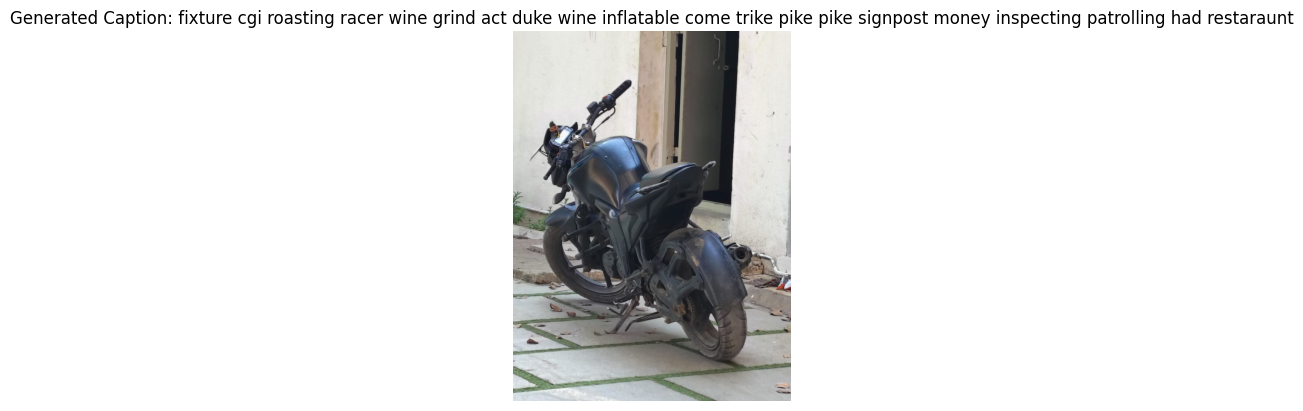

In [ ]:
from PIL import Image
import torch
from torchvision import transforms
from model import EncoderCNN, DecoderRNN
import os
import pickle
import matplotlib.pyplot as plt

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the necessary parameters
embed_size = 256
hidden_size = 512
vocab_file = "vocab.pkl"

# Load the vocabulary
vocab_path = os.path.join("/content/drive/MyDrive/cocoapi", vocab_file)
with open(vocab_path, "rb") as f:
    vocab = pickle.load(f)

vocab_size = len(vocab)

# Initialize the encoder and decoder.
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Moving models to the appropriate device
encoder.to(device)
decoder.to(device)

# Load the trained weights (Corrected path)
# Example of correct model saving during training
torch.save(encoder.state_dict(), '/content/models/encoder-2.pkl')
torch.save(decoder.state_dict(), '/content/models/decoder-2.pkl')

# Explicitly specify the full path
model_path = "/content/models" # Corrected path
encoder_file = "encoder-2.pkl" # Define encoder_file
decoder_file = "decoder-2.pkl" # Define decoder_file
encoder_model_path = os.path.join(model_path, encoder_file)
decoder_model_path = os.path.join(model_path, decoder_file)

# ... rest of the code ...

# Debugging prints
print(f"Encoder model path: {encoder_model_path}")
print(f"Decoder model path: {decoder_model_path}")
print(f"Contents of models directory: {os.listdir(model_path)}")
print(f"Current working directory: {os.getcwd()}")

# Attempt to load the encoder model with error handling
try:
    state_dict = torch.load(encoder_model_path, map_location=device)
    print("Encoder model loaded successfully.")
    print(f"State dict keys: {state_dict.keys()}")
    encoder.load_state_dict(state_dict)
except Exception as e:
    print(f"Error loading encoder model: {e}")

# Attempt to load the decoder model
try:
    decoder.load_state_dict(torch.load(decoder_model_path, map_location=device))
    print("Decoder model loaded successfully.")
except Exception as e:
    print(f"Error loading decoder model: {e}")

# Rest of your code...
# Set models to evaluation mode
encoder.eval()
decoder.eval()

# Load the test image
test_image_path = "/content/drive/MyDrive/cocoapi/3.jpeg"
test_image = Image.open(test_image_path).convert("RGB")

# Apply transformations to the test image
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Preprocess the test image
test_image = transform_test(test_image).unsqueeze(0)
test_image = test_image.to(device)

# Pass the test image through the encoder
with torch.no_grad():
    features = encoder(test_image).unsqueeze(1)

# Generate captions with the decoder
with torch.no_grad():
    output = decoder.sample(features)

def clean_sentence(generated_ids, idx2word):
    sampled_caption = []
    for word_id in generated_ids:
        if word_id in idx2word:
            word = idx2word[word_id]
            if word == '<end>':
                break
            sampled_caption.append(word)
    sentence = ' '.join(sampled_caption)
    return sentence

# Convert the output into a clean sentence using the defined function
caption = clean_sentence(output, vocab.idx2word)

# Display the test image with the generated caption
plt.imshow(Image.open(test_image_path))
plt.axis('off')
plt.title('Generated Caption: ' + caption)
plt.show()